## Our proposed model of `BART for Regression`

In [56]:
## Loading all the required libraries

import pandas as pd
import torch
from transformers import AutoModelForSeq2SeqLM, BartTokenizer
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

In [48]:
## Loading the dataset and splitting the test dataset for later
df = pd.read_csv("kidsInMindSubtitles2004.csv")
df = df[:1803].reset_index( drop = True)
df.shape

(1803, 15)

In [5]:
## Customizing the last layers of the BART model based on our task
model_name = "facebook/bart-large-cnn"  
class BartForRegression(torch.nn.Module):
    def __init__(self):
        super(BartForRegression, self).__init__()
        self.bart_model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large-cnn")
        self.dropout = torch.nn.Dropout(0.1)
        self.regression_head = torch.nn.Linear(self.bart_model.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bart_model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)

        hidden_state = outputs.decoder_hidden_states[-1]
        regression_output = self.regression_head(self.dropout(hidden_state[:, 0]))

        return regression_output.squeeze(-1)


In [6]:
## As we doing predicting modelling by predicting rating of the each movie. So setting the numclasses to 1
class SubtitlesDataset(Dataset):
    def __init__(self, texts, labels_regression, tokenizer, max_length):
        self.texts = texts
        self.labels_regression = labels_regression
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label_regression = float(self.labels_regression[idx])

        encoding = self.tokenizer(text, padding='max_length', truncation=True, max_length=self.max_length, return_tensors='pt')
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()

        return input_ids, attention_mask, label_regression


In [7]:
## As we doing predicting modelling by predicting rating of the each movie. So setting the numclasses to 1
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
model = BartForRegression()

In [8]:
## In this code cell we are splitting the train and validation datasets
texts = df['subtitles'].tolist()
labels_regression = df['Language'].tolist()
train_texts, val_texts, train_labels_regression, val_labels_regression = train_test_split(texts, 
                                                                                          labels_regression, 
                                                                                          test_size=0.1, 
                                                                                          random_state=42)

In [10]:
## By utilizing the dataloader class above we are creating train and validation dataloaders
train_dataset = SubtitlesDataset(train_texts, train_labels_regression, tokenizer, max_length=128)
val_dataset = SubtitlesDataset(val_texts, val_labels_regression, tokenizer, max_length=128)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

In [14]:

## Initializing the hyperparameters and lists for storing train and validation losses
optimizer = torch.optim.AdamW(model.parameters(), lr=2.2908675418875646e-06)
num_epochs = 25
train_losses = []
val_losses = []


for epoch in tqdm(range(num_epochs)):
    ## Training MODE
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader):
        input_ids, attention_mask, labels_regression = batch
        optimizer.zero_grad()

        regression_output = model(input_ids=input_ids, attention_mask=attention_mask)
        labels_regression = labels_regression.float()
        regression_output = regression_output.squeeze(-1)
        loss = torch.nn.functional.mse_loss(regression_output, labels_regression)
        #print(loss)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    ## Evaluation Mode
    model.eval()
    total_val_loss = 0
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels_regression = batch
            regression_output = model(input_ids=input_ids, attention_mask=attention_mask)
            regression_output = regression_output.squeeze(-1)
            val_loss = torch.nn.functional.mse_loss(regression_output, labels_regression)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_loss:.4f}")

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 1/25, Training Loss: 11.9859


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 2/25, Training Loss: 7.3656


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 3/25, Training Loss: 7.2158


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 4/25, Training Loss: 7.0026


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 5/25, Training Loss: 6.5869


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 6/25, Training Loss: 5.8212


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 7/25, Training Loss: 5.3396


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 8/25, Training Loss: 4.7318


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 9/25, Training Loss: 4.2205


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 10/25, Training Loss: 3.6741


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 11/25, Training Loss: 3.2991


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 12/25, Training Loss: 2.9071


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 13/25, Training Loss: 2.4910


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 14/25, Training Loss: 2.1485


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 15/25, Training Loss: 2.0274


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 16/25, Training Loss: 1.7539


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 17/25, Training Loss: 1.6754


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 18/25, Training Loss: 1.4983


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 19/25, Training Loss: 1.3127


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 20/25, Training Loss: 1.3267


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 21/25, Training Loss: 1.2626


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 22/25, Training Loss: 1.1365


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 23/25, Training Loss: 1.0827


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 24/25, Training Loss: 1.0456


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 25/25, Training Loss: 1.0093


In [17]:
## Storing the Loss values in dictionary for creating and storing the results in the dataframe
data = {'Epoch': range(1, num_epochs + 1),
        'Train Loss': train_losses,
        'Validation Loss': val_losses}

df2 = pd.DataFrame(data)
excel_filename = "losses_per_epoch2.xlsx"
df2.to_excel(excel_filename, index=False)
print("Train and Validation Losses per Epoch saved to:", excel_filename)


Train and Validation Losses per Epoch saved to: losses_per_epoch2.xlsx


In [26]:
#torch.save(model.state_dict(), 'models/BartForRegression.pth')

In [27]:
#model = BartForRegression()

In [28]:
#model.load_state_dict(torch.load('models/BartForRegression.pth'))

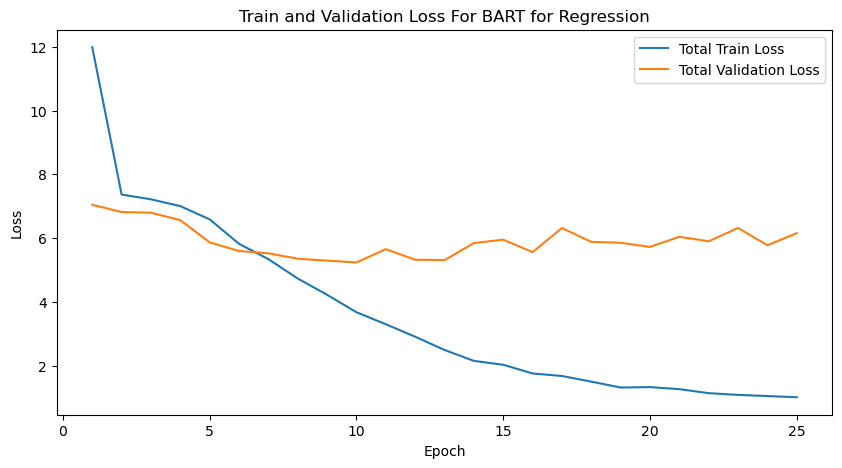

In [47]:
## Plotting the Loss values
df_excel=pd.read_excel("./losses_per_epoch2.xlsx")
plt.figure(figsize = (10, 5))
plt.plot(range(1, 26), df_excel['Train Loss'].tolist(), label='Total Train Loss')
plt.plot(range(1, 26), df_excel['Validation Loss'].tolist(), label='Total Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss For BART for Regression')
plt.legend()
plt.savefig("baseline_model_losses.pdf")
plt.show()


In [49]:
df = pd.read_csv("kidsInMindSubtitles2004.csv")
df = df[1803:].reset_index( drop = True)

In [50]:
predictions = []
for sub in tqdm(df.subtitles):
    inputs = tokenizer(sub, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']
    with torch.no_grad():
        regression_output = model(input_ids=input_ids, attention_mask=attention_mask).squeeze(-1)
        predicted_score = regression_output.item()
    predictions.append(predicted_score)

  0%|          | 0/201 [00:00<?, ?it/s]

In [54]:

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import numpy as np

df_predictions=pd.DataFrame({ 'Language_Score':df['Language'].tolist(),"Predcited_Score":predictions})

true_labels = np.array(df_predictions['Language_Score'].tolist())
predicted_scores=np.array(df_predictions['Predcited_Score'].tolist())
mse = mean_squared_error(true_labels, predicted_scores)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_labels, predicted_scores)
r2 = r2_score(true_labels, predicted_scores)
evs = explained_variance_score(true_labels, predicted_scores)

print("mse: ",mse)
print("rmse: ",rmse)
print("mae: ",mae)
print("r2: ",r2)
print("evs: ",evs)

mse:  2.2886737085737194
rmse:  1.5128363125512685
mae:  0.9744045878227671
r2:  0.7052711058621264
evs:  0.7287416666472817
